# Dataset
### 2017 ISIC Training Dataset
* 2000 images in JPEG format and CSV with clinical metadata
    - 374 images diagnosed as melanoma and 1626 images as other diagnoses lumped into non-melanoma
* image_id, age_approximate, and sex

## Importing Datasets and Data Cleaning

In [2]:
# import packages for data cleaning and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

# import packages for image processing and management
import pydicom as dicom
from random import randint
import os, sys, time, shutil, scipy, cv2, json, datetime, pydicom
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tqdm.notebook import tqdm
from skimage import io
from glob import glob
import albumentations as A
from PIL import Image
from skimage.color import label2rgb
import random

import warnings
warnings.simplefilter("ignore")

# import packages for modeling
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers, Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split

In [3]:
# import functions from utils.py
%reload_ext autoreload
%autoreload 2
from utils import *

### 2017 Training Dataset

In [7]:
# Upload 2017 Training metadata to determine any additional instances of minority class
train17a = pd.read_csv('data/ISIC-2017_Training_Part3_GroundTruth.csv')
train17a.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


In [8]:
train17a = train17a.drop(columns=['seborrheic_keratosis'], axis=1)
train17a.columns = ['file1', 'target']
train17a.target = train17a.target.astype(int)
train17a.head()

,file1,target
0,ISIC_0000000,0
1,ISIC_0000001,0
2,ISIC_0000002,1
3,ISIC_0000003,0
4,ISIC_0000004,1


In [9]:
train17b = pd.read_csv('data/ISIC-2017_Training_Data_metadata.csv')
train17b.head()

,image_id,age_approximate,sex
0,ISIC_0000000,55,female
1,ISIC_0000001,30,female
2,ISIC_0000002,60,female
3,ISIC_0000003,30,male
4,ISIC_0000004,80,male


In [10]:
train17b.columns = ['file', 'age', 'gender']
train17b = train17b.replace({'age': 'unknown'}, np.nan)
train17b = train17b.replace({'gender': 'unknown'}, np.nan)

In [36]:
train = pd.concat([train17b, train17a], axis=1)
train = train.drop(columns=['file1'], axis=1)
train.age = train[~train.age.isna()].age.astype(int)
train.head()

,file,age,gender,target
0,ISIC_0000000,55.0,female,0
1,ISIC_0000001,30.0,female,0
2,ISIC_0000002,60.0,female,1
3,ISIC_0000003,30.0,male,0
4,ISIC_0000004,80.0,male,1


In [12]:
train.target.value_counts()

0    1626
1     374
Name: target, dtype: int64

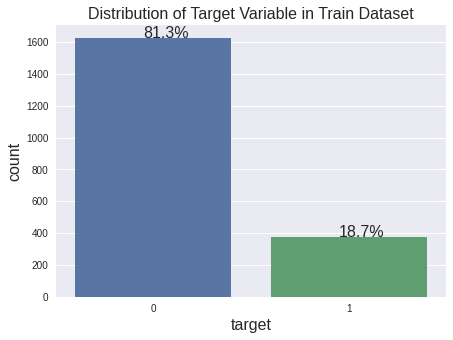

In [13]:
# create visualization for target variable distribution
def barplot(df, xlabel, ylabel, title):
    plt.figure(figsize = (7,5))
    ax = sns.countplot(x = xlabel, data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    total = len(df.target)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 16)
    plt.show()

barplot(train, 'target', 'count', 'Distribution of Target Variable in Train Dataset')

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    2000 non-null   object
 1   age     1744 non-null   object
 2   gender  1771 non-null   object
 3   target  2000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


In [15]:
# # write new dataframe to csv file
# train.to_csv('./data/train.csv')

## Validation and Testing Set

### Validation Set
Validation set is always created as a subset of the training data

### Testing Set

In [16]:
test1 = pd.read_csv('data/ISIC-2017_Test_v2_Data_metadata.csv')
test1.head()

,image_id,age_approximate,sex
0,ISIC_0012086,30,male
1,ISIC_0012092,40,male
2,ISIC_0012095,25,male
3,ISIC_0012134,75,female
4,ISIC_0012136,70,male


In [34]:
test1.columns = ['file', 'age', 'gender']
test1 = test1.replace({'age': 'unknown'}, np.nan)
test1 = test1.replace({'gender': 'unknown'}, np.nan)
test1.head()

,file,age,gender
0,ISIC_0012086,30,male
1,ISIC_0012092,40,male
2,ISIC_0012095,25,male
3,ISIC_0012134,75,female
4,ISIC_0012136,70,male


In [18]:
test2 = pd.read_csv('data/ISIC-2017_Test_v2_Part3_GroundTruth.csv')
test2.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0012086,0.0,1.0
1,ISIC_0012092,0.0,0.0
2,ISIC_0012095,0.0,0.0
3,ISIC_0012134,0.0,1.0
4,ISIC_0012136,0.0,1.0


In [19]:
test2 = test2.drop(columns=['seborrheic_keratosis'], axis=1)
test2.columns = ['file1', 'target']
test2.target = test2.target.astype(int)

In [35]:
test = pd.concat([test1, test2], axis=1)
test = test.drop(columns=['file1'], axis=1)
test.age = test[~test.age.isna()].age.astype(int)
test.target.value_counts()

0    483
1    117
Name: target, dtype: int64

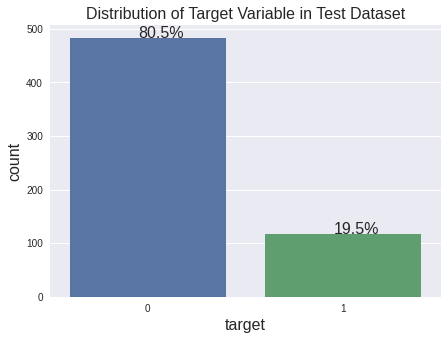

In [21]:
barplot(test, 'target', 'count', 'Distribution of Target Variable in Test Dataset')

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    600 non-null    object
 1   age     553 non-null    object
 2   gender  573 non-null    object
 3   target  600 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 18.9+ KB


In [23]:
# # save dataframe to file
# test.to_csv('./data/test_2017.csv')

# Data Understanding:
## Gender Distribution

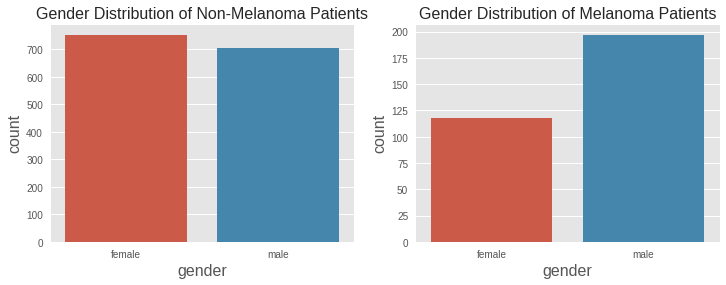

In [24]:
# display difference in gender distribution of melanoma vs. non-melanoma patients
def twoplot(data1, data2, xlabel, ylabel, title1, title2):
    plt.style.use('ggplot')
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    a = sns.countplot(x=xlabel, data=data1, ax=ax1)
    b = sns.countplot(x=xlabel, data=data2, ax=ax2)
    ax1.set_title(title1, fontsize=16)
    ax2.set_title(title2, fontsize=16)
    ax1.set_xlabel(xlabel, size=16)
    ax1.set_ylabel(ylabel, size=16)
    ax2.set_xlabel(xlabel, size=16)
    ax2.set_ylabel(ylabel, size=16)

twoplot(
    train[train.target == 0],
    train[train.target == 1],
    'gender',
    'count',
    "Gender Distribution of Non-Melanoma Patients",
    "Gender Distribution of Melanoma Patients"
)


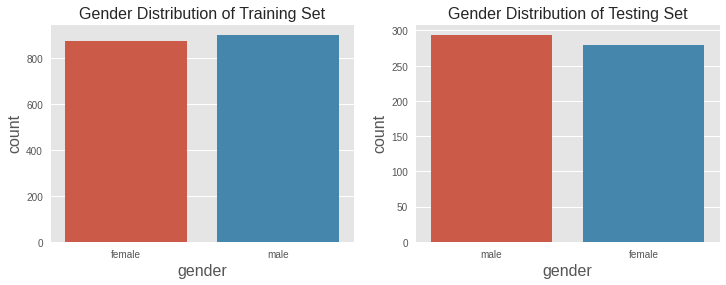

In [25]:
# display difference in gender distribution between training and testing datasets
twoplot(
    train,
    test,
    'gender',
    'count',
    "Gender Distribution of Training Set",
    "Gender Distribution of Testing Set"
)

## Age Distribution

Text(0, 0.5, 'Count')

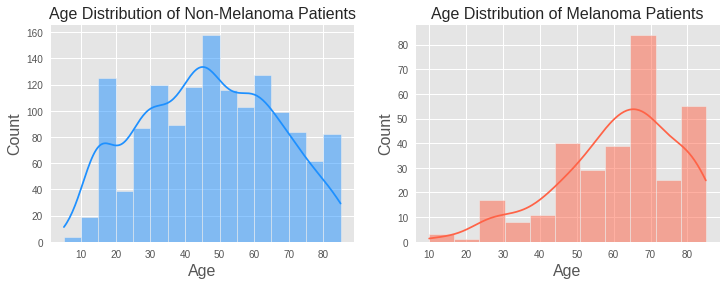

In [43]:
# display distribution of age for non-melanoma vs. melanoma patients
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='age', data=train[~train.age.isna()][train.target == 0], kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='age', data=train[~train.age.isna()][train.target == 1], kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Non-Melanoma Patients", fontsize=16)
ax2.set_title("Age Distribution of Melanoma Patients", fontsize=16)
ax1.set_xlabel('Age', size=16)
ax1.set_ylabel('Count', size=16)
ax2.set_xlabel('Age', size=16)
ax2.set_ylabel('Count', size=16)

Text(0.5, 1.0, 'Age Distribution of Testing Set')

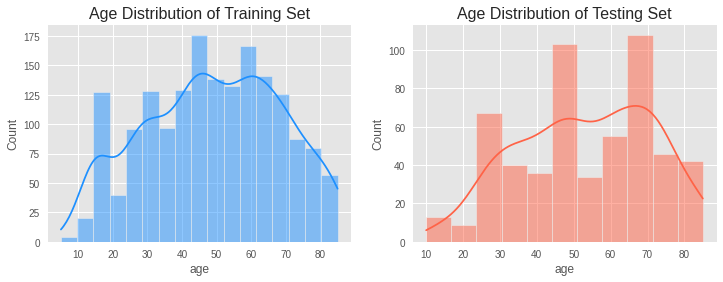

In [40]:
# display distribution of age between training and testing datasets
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='age', data=train[~train.age.isna()], kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='age', data=test[~test.age.isna()], kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Training Set", fontsize=16)
ax2.set_title("Age Distribution of Testing Set", fontsize=16)

# Train-Validation-Test Split
## Folder Management
Here is the folder structure:
* split
    * train
        * mel
        * not_mel
    * val
        * mel
        * not_mel
    test
        * mel
        * not_mel
        

In [44]:
# Train-Validation Split
df = pd.read_csv('data/train.csv')

# separate into melanoma and non-melanoma subsets
melanoma = df[df.target == 1]
non_melanoma = df[df.target == 0]

# separate into X and y for train_test_split
y_mel = melanoma.target
X_mel = melanoma.drop(columns=['target'], axis=1)
y_non_mel = non_melanoma.target
X_non_mel = non_melanoma.drop(columns=['target'], axis=1)

# train-validation split 80-20
X_tr_m, X_val_m, y_tr_m, y_val_m = train_test_split(X_mel, y_mel, random_state=42, test_size=0.2)
X_tr_nm, X_val_nm, y_tr_nm, y_val_nm = train_test_split(X_non_mel, y_non_mel, random_state=42, test_size=0.2)

# join X and y together
mel_train = pd.concat([X_tr_m, y_tr_m], axis=1)
non_mel_train = pd.concat([X_tr_nm, y_tr_nm], axis=1)
mel_val = pd.concat([X_val_m, y_val_m], axis=1)
non_mel_val = pd.concat([X_val_nm, y_val_nm], axis=1)

# join melanoma and non-melanoma subsets back together
train = pd.concat([mel_train, non_mel_train], axis=0)
validation = pd.concat([mel_val, non_mel_val], axis=0)
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)

# display first 5 rows of training dataset
train.head()

,Unnamed: 0,file,age,gender,target
0,955,ISIC_0011135,75.0,female,1
1,260,ISIC_0000311,60.0,female,1
2,341,ISIC_0000415,NaN,NaN,1
3,1975,ISIC_0015045,55.0,male,1
4,69,ISIC_0000074,25.0,male,1


In [45]:
len(train)

1599

In [46]:
train.target.value_counts()

0    1300
1     299
Name: target, dtype: int64

In [47]:
validation.head()

,Unnamed: 0,file,age,gender,target
0,1766,ISIC_0014360,75.0,male,1
1,140,ISIC_0000154,NaN,NaN,1
2,54,ISIC_0000056,55.0,female,1
3,1759,ISIC_0014331,60.0,female,1
4,242,ISIC_0000285,60.0,male,1


In [48]:
len(validation)

401

In [49]:
validation.target.value_counts()

0    326
1     75
Name: target, dtype: int64

In [50]:
test.head()

,file,age,gender,target
0,ISIC_0012086,30.0,male,0
1,ISIC_0012092,40.0,male,0
2,ISIC_0012095,25.0,male,0
3,ISIC_0012134,75.0,female,0
4,ISIC_0012136,70.0,male,0


In [51]:
test.target.value_counts()

0    483
1    117
Name: target, dtype: int64

In [52]:
# train.to_csv("./data/tr.csv")
# validation.to_csv("./data/val.csv")
# test.to_csv("./data/tt.csv")

## Forming Folders for Training-Validation-Testing Datasets

In [55]:
# Make new directories and assign directory variables
new_dir = 'split/'
try:
    os.mkdir(new_dir)
except:
    print('Directory already exists')
else:
    print('Directory created successfully')

Directory already exists


### Creating Training Dataset

In [56]:
# Make subfolders for melanoma and non-melanoma images
tr_fldr = os.path.join(new_dir, 'train')
tr_mel = os.path.join(tr_fldr, 'mel')
tr_nm = os.path.join(tr_fldr, 'not_mel')

In [61]:
for path in [tr_fldr, tr_mel, tr_nm]:
    try:
        os.mkdir(path)
    except:
        print('Directory already exists')
    else:
        print('Directory created successfully')


Directory already exists
Directory already exists
Directory created successfully


In [62]:
# separate melanoma from non-melanoma in dataframe
train['jpg'] = train.file.apply(lambda x: str(x) + '.jpg')
mel_train = train[train.target == 1]
non_mel_train = train[train.target == 0]

In [63]:
# turn all image files into a list to insert into for loop
images_dir = 'data/ISIC-2017_Training_Data'
mel_tr_ids = mel_train.jpg.to_list()
nm_tr_ids = non_mel_train.jpg.to_list()

In [65]:
# move all melanoma images into subfolder
for img in tqdm (mel_tr_ids):
    shutil.copyfile(os.path.join(images_dir, img), os.path.join(tr_mel, img))

  0%|          | 0/299 [00:00<?, ?it/s]

In [66]:
# move non-melanoma imgaes into subfolder
for img in tqdm(nm_tr_ids):
    shutil.copyfile(os.path.join(images_dir, img), os.path.join(tr_nm, img))

  0%|          | 0/1300 [00:00<?, ?it/s]

## Creating Validation Dataset

In [67]:
# Make subfolders for melanoma and non-melanoma images
val_fldr = os.path.join(new_dir, 'val')
val_mel = os.path.join(val_fldr, 'mel')
val_nm = os.path.join(val_fldr, 'not_mel')

In [68]:
for path in [val_fldr, val_mel, val_nm]:
    try:
        os.mkdir(path)
    except:
        print('Directory already exists')
    else:
        print('Directory created successfully')

Directory created successfully
Directory created successfully
Directory created successfully


In [69]:
# separate melanoma from non-melanoma in dataframe
validation['jpg'] = validation.file.apply(lambda x: str(x) + '.jpg')
mel_val = validation[validation.target == 1]
nm_val = validation[validation.target == 0]

In [70]:
# turn all image files into a list to insert into for loop
images_dir = 'data/ISIC-2017_Training_Data'
mel_val_ids = mel_val.jpg.to_list()
nm_val_ids = nm_val.jpg.to_list()

In [72]:
# move all melanoma images into subfolder
for img in tqdm(mel_val_ids):
    shutil.copyfile(os.path.join(images_dir, img), os.path.join(val_mel, img))

  0%|          | 0/75 [00:00<?, ?it/s]

In [73]:
# move non-melanoma imgaes into subfolder
for img in tqdm(nm_val_ids):
    shutil.copyfile(os.path.join(images_dir, img), os.path.join(val_nm, img))

  0%|          | 0/326 [00:00<?, ?it/s]

## Creating Testing Set

In [75]:
# Make subfolders for melanoma and non-melanoma images
test_fldr = os.path.join(new_dir, 'test')
test_mel = os.path.join(test_fldr, 'mel')
test_nm = os.path.join(test_fldr, 'not_mel')

In [76]:
for path in [test_fldr, test_mel, test_nm]:
    try:
        os.mkdir(path)
    except:
        print('Directory already exists')
    else:
        print('Directory created successfully')

Directory created successfully
Directory created successfully
Directory created successfully


In [77]:
# separate melanoma from non-melanoma in dataframe
test['jpg'] = test.file.apply(lambda x: str(x) + '.jpg')
mel_test = test[test.target == 1]
non_mel_test = test[test.target == 0]

In [78]:
# turn all image files into a list to insert into for loop
images_dir = 'data/ISIC-2017_Test_v2_Data'
mel_test_ids = mel_test.jpg.to_list()
nm_test_ids = non_mel_test.jpg.to_list()

In [79]:
# move all melanoma images into subfolder
for img in tqdm (mel_test_ids):
    shutil.copyfile(os.path.join(images_dir, img), os.path.join(test_mel, img))

  0%|          | 0/117 [00:00<?, ?it/s]

In [80]:
# move non-melanoma imgaes into subfolder
for img in tqdm(nm_test_ids):
    shutil.copyfile(os.path.join(images_dir, img), os.path.join(test_nm, img))

  0%|          | 0/483 [00:00<?, ?it/s]

# Modeling Process
## Discussion of Parameters
1. For test_generator, shuffle must be set to False, and batch size should be set to 1 in order for the step size equal to the length of test dataset. What I mean is that the batch size should be the length of the dataset, but using the formula of length (n) divided by batch size for training and validation would mean batch size for testing is 1.

2. Images must be normalized with datagen = ImageDataGenerator(rescale=1./255). Normalization is scaling data to the range of 0-1, and we do that by using the ratio 1.0/255.0 since pixel values range from 0 to 255.

3. Different models will require different input size, i.e. AlexNet has image input size of (224, 224, 3), so be sure to check what is the input size for each model.

## Discussion of Callbacks
Using the callbacks in Keras allowed me to reproduce the visualizations and the metrics from the training process and save some time not having to rerun the models


# Evaluation Process:
## Discussion of Metrics Used:
* **Accuracy** is not useful by itself for extremely imbalanced datasets, since a high Accuracy is easily achieved by just predicting majority class. It is the default metric for classification algorithms.

* **Precision** tells us how many of the correctly predicted cases actually turned out to be positive. This was the least telling of all the metrics, as it was skewed towards 1.0 in almost all the iterations. I like to think of this as how many selected items are relevant, where selection is what I labeled as a particular class. Out of TP and FP, how many were TPs?

* **Recall** tells us how many of the actual positive cases we were able to predict correctly with our model. Recall is a useful metric in cases where False Negative trumps False Positive. Recall is the relevant items retrieved out of total relevant items. All relevant items are of one class. So it is concerned with the members of just one class, aka FN and TP, and is not concerned with the other class entirely.

* **ROC-AUC** plots FPR (x-axis) vs. TPR (y-axis), and can be thought of as the fraction of correct predictions versus the fraction of errors for the negative class. It is a measure of the disciminative power between the positive and negative classes. At an AUC score of 0.50, a classifier basically has no discriminative power between the two classes as is the case when there is a FPR and TPR of 0 (predicting all as negative class) or FPR and TPR of 1 (predicting all as positive class), which produces a diagonal line from the lower left to upper right. For imbalanced datasets, this is most commonly used metric to compare classification models.

* **PR-AUC** plots recall (x-axis) vs. precision (y-axis), which are both focused on the positive class and not the negative class. A no-skill classifier would produce a horizontal line close to the x-axis where precision is equal to 0.50. This metric is useful in imbalanced datasets where ROC/AUC scores are giving overly optimistic scores.

## Simplified Convolutional Neural Network

In [8]:
# load saved model from manual save
model_2 = load_model('logs/log_cnn/model.05-0.54.hdf5')

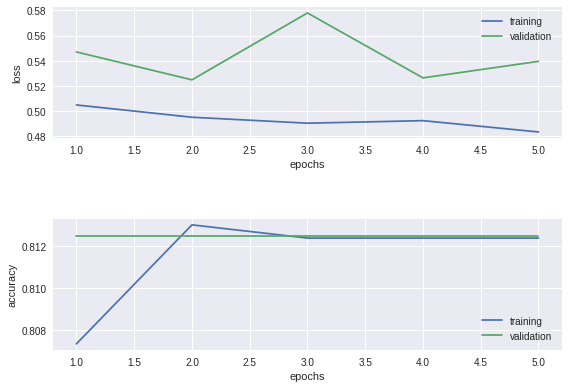

In [9]:
# load training metrics from CSVlogger into dataframe
history_cnn = pd.read_csv("logs/log_cnn/log.csv")
# display accuracy and loss graphs during training process of model
train_val_metrics2(5, history_cnn)


In [10]:
for (i, column) in enumerate(history_cnn.columns, start=0):
    print(i, column)

0 epoch
1 accuracy
2 auc_16
3 auc_17
4 loss
5 lr
6 precision_8
7 recall_8
8 val_accuracy
9 val_auc_16
10 val_auc_17
11 val_loss
12 val_precision_8
13 val_recall_8


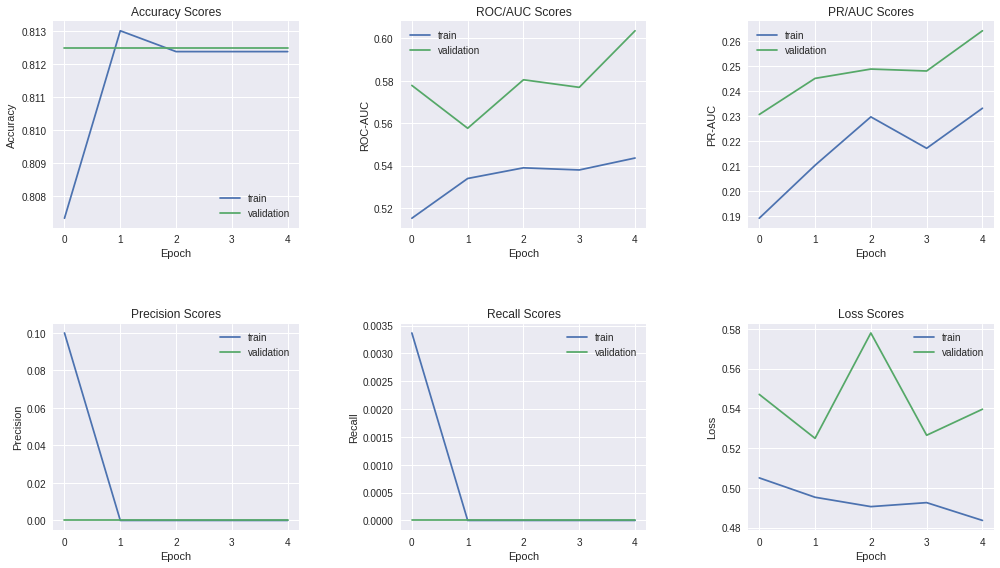

In [11]:
# display metrics in graphs plotting said metric vs. epoch
sixplot2(
    var=history_cnn,
    auc=history_cnn.columns[2],
    v_auc=history_cnn.columns[9],
    pr_auc=history_cnn.columns[3],
    v_pr_auc=history_cnn.columns[10],
    prec=history_cnn.columns[6],
    v_prec=history_cnn.columns[12],
    rec=history_cnn.columns[7],
    v_rec=history_cnn.columns[13])

In [12]:
# define test generator for predicting
test_fldr = './split/test'
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
print(f'STEP_SIZE_TEST: {STEP_SIZE_TEST}')

Found 600 images belonging to 2 classes.
STEP_SIZE_TEST: 600


600/600 [==============================] - 279s 461ms/step


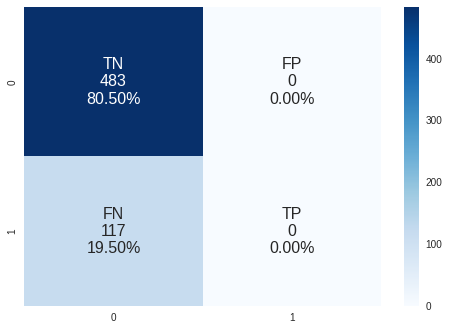

In [13]:
# display confusion matrix visualization for model
test_generator.reset()
pred_2 = model_2.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_2 = pred_2 > 0.5
make_confusion_matrix(y_true, y_pred_2)

In [14]:
# get testing accuracy and loss for model prediction
test_generator.reset()
score_2 = model_2.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score_2[0]))
print("Accuracy: " + str(score_2[1]))
print("Precision: " + str(score_2[2]))
print("Recall: " + str(score_2[3]))
print("ROC-AUC: " + str(score_2[4]))
print("PR-AUC: " + str(score_2[5]))

600/600 [==============================] - 281s 461ms/step - loss: 0.5673 - accuracy: 0.8050 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - auc_16: 0.5104 - auc_17: 0.1904
Loss: 0.5672804117202759
Accuracy: 0.8050000071525574
Precision: 0.0
Recall: 0.0
ROC-AUC: 0.5103961825370789
PR-AUC: 0.19038429856300354


## ResNet50 Architecture

In [47]:
# load saved model
model_5 = load_model('logs/log_resnet/model.05-0.48.hdf5')

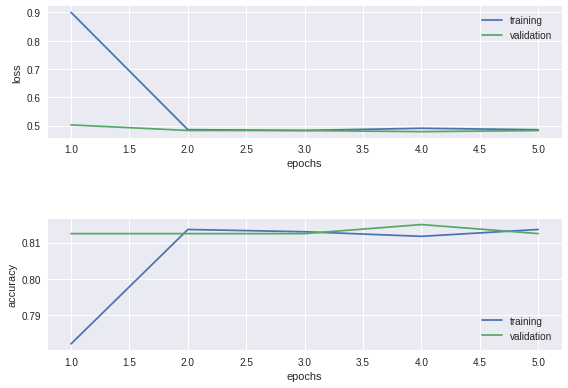

In [41]:
# upload training metrics from CSVLogger into dataframe
history_res = pd.read_csv("logs/log_resnet/log.csv")
# display loss and accuracy graphs from training
train_val_metrics2(5, history_res)

In [36]:
for (i, column) in enumerate(history_res.columns, start=0):
    print(i, column)

0 epoch
1 accuracy
2 auc_20
3 auc_21
4 loss
5 lr
6 precision_10
7 recall_10
8 val_accuracy
9 val_auc_20
10 val_auc_21
11 val_loss
12 val_precision_10
13 val_recall_10


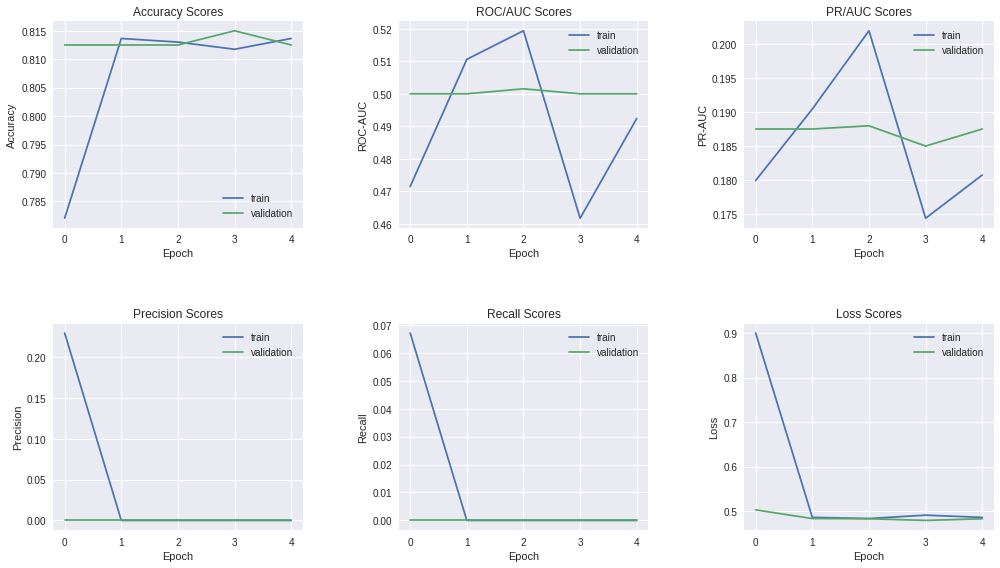

In [37]:
# display metrics in graphs plotting said metric vs. epoch
sixplot2(
    var=history_res,
    auc=history_res.columns[2],
    v_auc=history_res.columns[9],
    pr_auc=history_res.columns[3],
    v_pr_auc=history_res.columns[10],
    prec=history_res.columns[6],
    v_prec=history_res.columns[12],
    rec=history_res.columns[7],
    v_rec=history_res.columns[13])

In [48]:
# define test generator for predicting
test_fldr = './split/test'
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
print(f'STEP_SIZE_TEST: {STEP_SIZE_TEST}')

Found 600 images belonging to 2 classes.
STEP_SIZE_TEST: 600


600/600 [==============================] - 297s 490ms/step


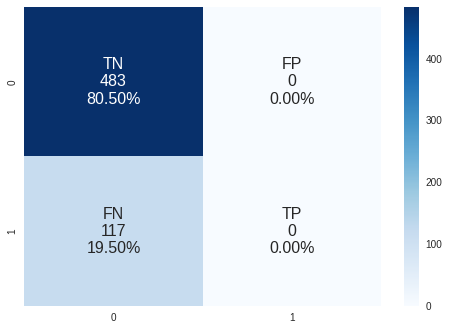

In [49]:
# visualize confusion matrix for model
test_generator.reset()
pred_5 = model_5.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_5 = pred_5 > 0.5
make_confusion_matrix(y_true, y_pred_5)

In [50]:
# get testing metrics for model
test_generator.reset()
score_5 = model_5.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score_5[0]))
print("Accuracy: " + str(score_5[1]))
print("Precision: " + str(score_5[2]))
print("Recall: " + str(score_5[3]))
print("ROC-AUC: " + str(score_5[4]))
print("PR-AUC: " + str(score_5[5]))

600/600 [==============================] - 354s 524ms/step - loss: 0.4934 - accuracy: 0.8050 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - auc_20: 0.5000 - auc_21: 0.1950
Loss: 0.49341002106666565
Accuracy: 0.8050000071525574
Precision: 0.0
Recall: 0.0
ROC-AUC: 0.5
PR-AUC: 0.19499999284744263


## MobileNet Architecture

In [15]:
# load saved model
model_6 = load_model('logs/log_mobilenet/model.05-0.42.hdf5')

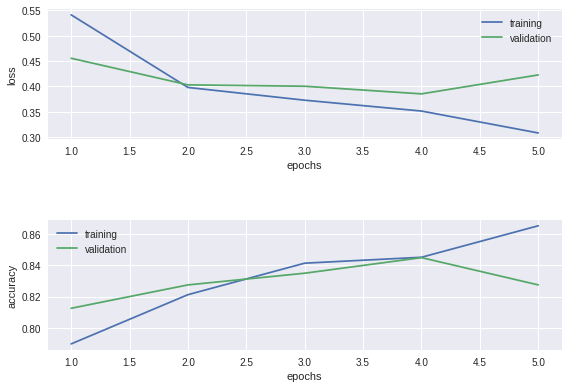

In [16]:
# display loss and accuracy graphs from training
history_mobi = pd.read_csv("logs/log_mobilenet/log.csv")
train_val_metrics2(5, history_mobi)

In [54]:
for (i, column) in enumerate(history_mobi.columns, start=0):
    print(i, column)


0 epoch
1 accuracy
2 auc_6
3 auc_7
4 loss
5 lr
6 precision_3
7 recall_3
8 val_accuracy
9 val_auc_6
10 val_auc_7
11 val_loss
12 val_precision_3
13 val_recall_3


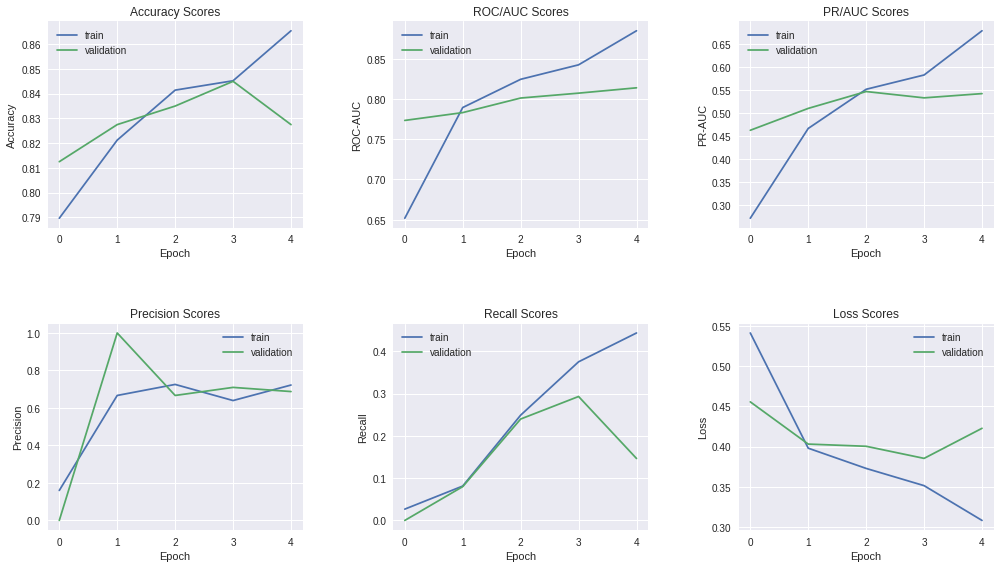

In [17]:
# display metrics in graphs plotting said metric vs. epoch
sixplot2(
    var=history_mobi,
    auc=history_mobi.columns[2],
    v_auc=history_mobi.columns[9],
    pr_auc=history_mobi.columns[3],
    v_pr_auc=history_mobi.columns[10],
    prec=history_mobi.columns[6],
    v_prec=history_mobi.columns[12],
    rec=history_mobi.columns[7],
    v_rec=history_mobi.columns[13])

In [18]:
# define test generator for predicting
test_fldr = './split/test'
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
print(f'STEP_SIZE_TEST: {STEP_SIZE_TEST}')
print(test_generator.class_indices)

Found 600 images belonging to 2 classes.
STEP_SIZE_TEST: 600
{'0_not_mel': 0, '1_mel': 1}


In [19]:
# display visualization of confusion matrix for model
test_generator.reset()
pred_6 = model_6.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_6 = pred_6 > 0.5


600/600 [==============================] - 261s 432ms/step


In [20]:
unique, counts = np.unique(y_pred_6, return_counts=True)
dict(zip(unique, counts))


{False: 569, True: 31}

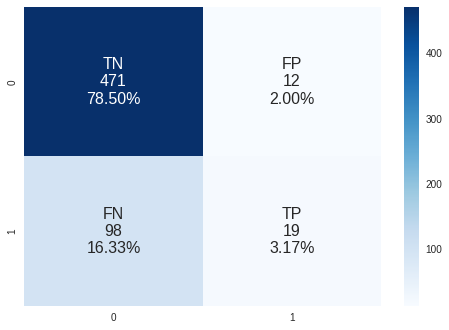

In [21]:
make_confusion_matrix(y_true, y_pred_6)

In [22]:
# get testing metrics for model
test_generator.reset()

score_6 = model_6.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score_6[0]))
print("Accuracy: " + str(score_6[1]))
print("Precision: " + str(score_6[2]))
print("Recall: " + str(score_6[3]))
print("ROC-AUC: " + str(score_6[4]))
print("PR-AUC: " + str(score_6[5]))

600/600 [==============================] - 269s 444ms/step - loss: 0.4906 - accuracy: 0.8167 - precision_3: 0.6129 - recall_3: 0.1624 - auc_6: 0.7489 - auc_7: 0.4552
Loss: 0.49064400792121887
Accuracy: 0.8166666626930237
Precision: 0.6129032373428345
Recall: 0.16239316761493683
ROC-AUC: 0.7488807439804077
PR-AUC: 0.4551522731781006


# Metrics

In [51]:
data = {'Accuracy': [score_2[1], score_5[1], score_6[1]],
        'Precision': [score_2[2], score_5[2], score_6[2]],
        'Recall': [score_2[3], score_5[3], score_6[3]],
        'ROC-AUC': [score_2[4], score_5[4], score_6[4]],
        'PR-AUC': [score_2[5], score_5[5], score_6[5]]}
metrics = pd.DataFrame(data=data, index=['Simplified CNN',
                                             'ResNet50',
                                             'MobileNet'])

In [52]:
metrics.to_csv("data/metrics.csv")
metrics

,Accuracy,Precision,Recall,ROC-AUC,PR-AUC
Simplified CNN,0.805000,0.000000,0.000000,0.510396,0.190384
ResNet50,0.805000,0.000000,0.000000,0.500000,0.195000
MobileNet,0.816667,0.612903,0.162393,0.748881,0.455152
